In [ ]:
!pip install requests

In [ ]:
!pip install keras

In [ ]:
!pip install torch

In [2]:
import torch

torch.cuda.is_available()

True

In [2]:
import requests
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

CSV_URL = 'https://www.cryptodatadownload.com/cdd/Bitfinex_BTCUSD_d.csv'

with requests.Session() as s:
    download = s.get(CSV_URL)

    decoded_content = download.content.decode('utf-8')

    res = csv.reader(decoded_content.splitlines(), delimiter=',')
    BTC_list = list(res)
    
    BTC_df = pd.DataFrame(data=BTC_list[2:], columns=BTC_list[1])
    

BTC_df.dtypes

unix          object
date          object
symbol        object
open          object
high          object
low           object
close         object
Volume USD    object
Volume BTC    object
dtype: object

In [3]:
BTC_df.columns

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume USD',
       'Volume BTC'],
      dtype='object')

In [4]:
for column in BTC_df.columns[3:]:
    BTC_df[column] = BTC_df[column].astype('float')
BTC_df.dtypes

unix           object
date           object
symbol         object
open          float64
high          float64
low           float64
close         float64
Volume USD    float64
Volume BTC    float64
dtype: object

In [5]:
BTC_df.set_index("unix", inplace=True)
BTC_df = BTC_df[::-1]
BTC_df.reset_index(inplace=True)
BTC_df.drop("unix", axis=1, inplace=True)

BTC_df['date'] = pd.to_datetime(BTC_df['date'])

BTC_df

,date,symbol,open,high,low,close,Volume USD,Volume BTC
0,2015-02-09,BTC/USD,224.220000,225.000000,215.40,220.610000,6.493501e+06,29625.030000
1,2015-02-10,BTC/USD,220.610000,223.880000,214.00,220.960000,6.402351e+06,29268.950000
2,2015-02-11,BTC/USD,220.960000,224.400000,218.10,219.190000,4.268987e+06,19289.280000
3,2015-02-12,BTC/USD,219.190000,223.200000,217.87,222.600000,2.468883e+06,11190.650000
4,2015-02-13,BTC/USD,222.390000,241.760000,221.46,236.000000,6.806973e+06,29079.110000
...,...,...,...,...,...,...,...,...
2619,2022-04-12,BTC/USD,39560.178051,40770.000000,39300.00,40088.000000,1.646530e+08,4107.289755
2620,2022-04-13,BTC/USD,40096.000000,41555.000000,39607.00,41155.000000,1.880015e+08,4568.132992
2621,2022-04-14,BTC/USD,41166.000000,41511.000000,39575.00,39948.000000,1.264516e+08,3165.403817
2622,2022-04-15,BTC/USD,39948.012346,40873.000000,39777.00,40586.355501,8.950388e+07,2205.270172


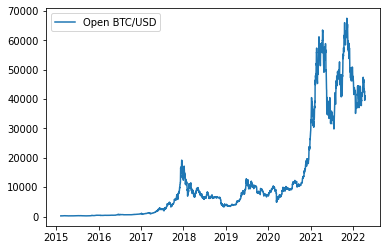

In [6]:
plt.plot(BTC_df['date'], BTC_df['open'], label="Open BTC/USD")
plt.legend()  #  Отобразить легенду
plt.show()  #  Отобразить график

In [7]:
from sklearn.preprocessing import MinMaxScaler

minmaxscale = MinMaxScaler()

close_price = BTC_df['close'].values.reshape(-1, 1)

scaled_close = minmaxscale.fit_transform(close_price)

scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [8]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

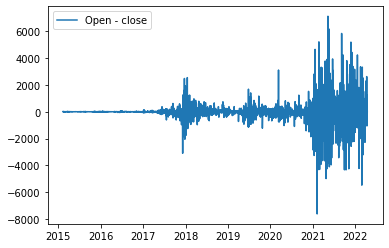

In [9]:
plt.plot(BTC_df['date'], BTC_df['open'] - BTC_df['close'], label="Open - close")
plt.legend()  #  Отобразить легенду
plt.show()  #  Отобразить график

In [10]:
#  Feature Enginnering
#  Добавление новых колонок на основе имеющихся.

BTC_df['open_close_diff'] = BTC_df['open'] - BTC_df['close']
BTC_df['high_low_diff'] = BTC_df['high'] - BTC_df['low']
BTC_df['open_to_high'] = BTC_df['open_close_diff'] / BTC_df['high_low_diff']

<AxesSubplot:>

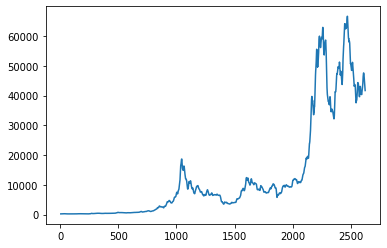

In [11]:
BTC_df['high'].rolling(window=7).mean().plot()  #  Средняя цена за 7 дней

In [12]:
BTC_df['high_mean_7d'] = BTC_df['high'].shift(1).rolling(window=7).mean()
BTC_df['max_open_7d'] = BTC_df['open'].shift(1).rolling(window=7).max()
BTC_df['min_close_7d'] = BTC_df['close'].shift(1).rolling(window=7).min()

In [13]:
BTC_df.groupby(BTC_df['date'].dt.weekday)['Volume BTC'].mean()

date
0    18487.985172
1    19430.872601
2    20292.541952
3    20279.941755
4    20486.496414
5    15113.853717
6    15402.415188
Name: Volume BTC, dtype: float64

<AxesSubplot:xlabel='date'>

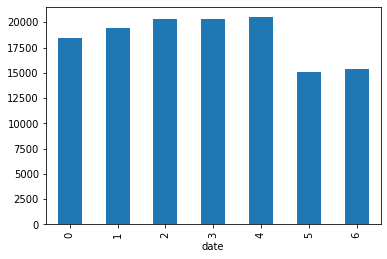

In [14]:
BTC_df.groupby(BTC_df['date'].dt.weekday)['Volume BTC'].mean().plot(kind='bar')

In [15]:
for day in range(1, 8):
    BTC_df[f'close_{day}d'] = BTC_df['close'].shift(day)

In [16]:
BTC_df.head(20)

,date,symbol,open,high,low,close,Volume USD,Volume BTC,open_close_diff,high_low_diff,...,high_mean_7d,max_open_7d,min_close_7d,close_1d,close_2d,close_3d,close_4d,close_5d,close_6d,close_7d
0,2015-02-09,BTC/USD,224.22,225.00,215.40,220.61,6493501.42,29625.03,3.61,9.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-10,BTC/USD,220.61,223.88,214.00,220.96,6402350.57,29268.95,-0.35,9.88,...,NaN,NaN,NaN,220.61,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-02-11,BTC/USD,220.96,224.40,218.10,219.19,4268986.79,19289.28,1.77,6.30,...,NaN,NaN,NaN,220.96,220.61,NaN,NaN,NaN,NaN,NaN
3,2015-02-12,BTC/USD,219.19,223.20,217.87,222.60,2468883.37,11190.65,-3.41,5.33,...,NaN,NaN,NaN,219.19,220.96,220.61,NaN,NaN,NaN,NaN
4,2015-02-13,BTC/USD,222.39,241.76,221.46,236.00,6806972.89,29079.11,-13.61,20.30,...,NaN,NaN,NaN,222.60,219.19,220.96,220.61,NaN,NaN,NaN
5,2015-02-14,BTC/USD,236.13,261.30,235.51,258.12,10739014.48,42984.94,-21.99,25.79,...,NaN,NaN,NaN,236.00,222.60,219.19,220.96,220.61,NaN,NaN
6,2015-02-15,BTC/USD,257.00,266.84,228.20,234.14,17384420.70,71361.28,22.86,38.64,...,NaN,NaN,NaN,258.12,236.00,222.60,219.19,220.96,220.61,NaN
7,2015-02-16,BTC/USD,234.14,243.65,228.62,236.78,10798751.12,45750.85,-2.64,15.03,...,238.054286,257.00,219.19,234.14,258.12,236.00,222.60,219.19,220.96,220.61
8,2015-02-17,BTC/USD,236.78,246.28,231.50,242.87,10228035.45,42669.08,-6.09,14.78,...,240.718571,257.00,219.19,236.78,234.14,258.12,236.00,222.60,219.19,220.96
9,2015-02-18,BTC/USD,242.87,244.99,231.01,234.80,9164141.83,38588.38,8.07,13.98,...,243.918571,257.00,219.19,242.87,236.78,234.14,258.12,236.00,222.60,219.19


In [17]:
#  BTC_df.drop('date', axis=1, inplace=True)
#  BTC_df.drop('symbol', axis=1, inplace=True)
BTC_df['target'] = BTC_df['close'].shift(-1)
BTC_df.dropna(inplace=True)

In [ ]:
X, y = BTC_df.drop('target', axis=1), BTC_df['target']

In [ ]:
y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, max_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
pd.DataFrame(data=[model.feature_importances_], columns=X.columns).T

In [9]:
import keras

SEQ_LEN = 100
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(keras.layers.Bidirectional(
  keras.layers.CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(keras.layers.Dropout(rate=DROPOUT))

model.add(keras.layers.Bidirectional(
  keras.layers.CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(keras.layers.Dropout(rate=DROPOUT))

model.add(keras.layers.Bidirectional(
  keras.layers.CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(keras.layers.Dense(units=1))

model.add(keras.layers.Activation('linear'))

In [ ]:
BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=1,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

In [ ]:
y_hat = model.predict(X_test)
mean_absolute_error(y_hat, y_test)